In [52]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from utils.prep_dataset import prepare_df
from utils.popular_model import top_prediction
from utils.create_features import stat_features
from utils.tools import generate_lightfm_recs_mapper, compute_metrics

In [53]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [54]:
TOP_CANDIDATES = 30
TOP_FOR_TEST = 200

In [55]:
df = pd.read_csv('../data/prepare_data.csv')

df['user_id'] = df.groupby(['Телефон_new', 'ЭлектроннаяПочта_new']).ngroup()
df = df[(df['Цена'] > 0) & (df['Количество'] > 0)] # оставляем товары, стоимость которых больше 0
df = df.drop_duplicates()
df = df.dropna(subset=['item_name']) # удаляем случаи, когда товары неизветны (посмореть их долю)
df = df.dropna(subset=['user_id']) # удаляем user_id, у которых неизветны айдишники (посмореть их долю)
df['item_id'] = df.groupby(['item_name', 'Группа2']).ngroup() #create item_id
df['user_id'] = df.apply(lambda x: int(x['user_id']), axis=1)

## Делим на test - train

На test оставим последние 7 дней

In [56]:
df['date'] = pd.to_datetime(df['date'])
max_date = df['date'].max()

df_1lvl = df[['user_id', 'item_id', 'Количество', 'date']]
df_1lvl['qty'] = df_1lvl.groupby(['user_id', 'item_id', 'date'])['Количество'].transform(sum)
df_1lvl = df_1lvl[['user_id', 'item_id', 'qty', 'date']].drop_duplicates()

In [57]:
train = df_1lvl[(df_1lvl['date'] < max_date - pd.Timedelta(days=7))]
test = df_1lvl[(df_1lvl['date'] >= max_date - pd.Timedelta(days=7))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (332153, 4)
test: (48753, 4)


In [58]:
for_1lvl_date_threshold = train['date'].quantile(q=0.5, interpolation='nearest')
for_1lvl_date_threshold

Timestamp('2017-05-25 00:00:00')

In [59]:
train_1lvl = train[(train['date'] < for_1lvl_date_threshold)]
pred_1lvl = train[(train['date'] >= for_1lvl_date_threshold)]

print(f"train: {train_1lvl.shape}")
print(f"pred: {pred_1lvl.shape}")

train: (163057, 4)
pred: (169096, 4)


In [60]:
train_1lvl['i_qty'] = train_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)
train_1lvl['last_dt'] = train_1lvl.groupby(['user_id', 'item_id']).date.transform(max)
train_1lvl['last_week_day'] = train_1lvl.apply(lambda x: x['last_dt'].weekday(), axis=1)
train_1lvl['last_month'] = train_1lvl.apply(lambda x: x['last_dt'].month, axis=1)

# преобразуем в матрицу user-item-ranting
train_1lvl = train_1lvl[['user_id', 'item_id', 'last_month', 'last_week_day', 'i_qty']].drop_duplicates()

print(f" train lvl1: {train_1lvl.shape}")

 train lvl1: (152702, 5)


In [61]:
#train_1lvl['i_qty'] = train_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)
pred_1lvl['i_qty'] = pred_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)

# преобразуем в матрицу user-item-ranting
#train_1lvl = train_1lvl[['user_id', 'item_id', 'i_qty']].drop_duplicates()
pred_1lvl = pred_1lvl[['user_id', 'item_id', 'i_qty']].drop_duplicates()

print(f"lfm_train: {train_1lvl.shape}")
print(f"lfm_pred: {pred_1lvl.shape}")

lfm_train: (152702, 5)
lfm_pred: (157342, 3)


In [62]:
test['i_qty'] = test.groupby(['user_id', 'item_id'])['qty'].transform(sum)
test = test[['user_id', 'item_id', 'i_qty']].drop_duplicates()
# оставляем только теплых пользователей
test = test[test['user_id'].isin(train_1lvl['user_id'].unique())]

In [63]:
train['i_qty'] = train.groupby(['user_id', 'item_id'])['qty'].transform(sum)
train['last_dt'] = train.groupby(['user_id', 'item_id']).date.transform(max)
train['last_week_day'] = train.apply(lambda x: x['last_dt'].weekday(), axis=1)
train['last_month'] = train.apply(lambda x: x['last_dt'].month, axis=1)

# преобразуем в матрицу user-item-ranting
train = train[['user_id', 'item_id', 'last_month', 'last_week_day', 'i_qty']].drop_duplicates()

print(f" train: {train.shape}")

 train: (296537, 5)


# Level 1
## Считываем кандидатов от моделей первого уровня 
- NCF
- LightFM
- Popular items

In [64]:
candidates_lghtfm = pd.read_csv('../prediction_1lvl_models/top30_candidates_lghtfm.csv').drop(columns='index')
candidates_popular = pd.read_csv('../prediction_1lvl_models/top30_candidates_popular.csv').drop(columns='index')
candidates_ncf = pd.read_csv('../prediction_1lvl_models/top30_candidates_ncf.csv')

In [65]:
lfm = pd.read_csv('../prediction_1lvl_models/top200_candidates_lfm.csv')
popular = pd.read_csv('../prediction_1lvl_models/top200_candidates_popular.csv')
ncf = pd.read_csv('../prediction_1lvl_models/top200_candidates_ncf.csv')

## 1) Метрики качества моделей первого уровня

In [66]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(train_1lvl['user_id'].unique())]

In [67]:
lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm, 
                              top_N=15, rank_col='lfm_rank')
lfm_metrics

Precision@1     0.211480
Recall@1        0.094210
Precision@2     0.189728
Recall@2        0.163577
Precision@3     0.131319
Recall@3        0.167780
Precision@4     0.115559
Recall@4        0.183493
Precision@5     0.097100
Recall@5        0.195082
Precision@6     0.087261
Recall@6        0.202511
Precision@7     0.077514
Recall@7        0.207988
Precision@8     0.076473
Recall@8        0.223950
Precision@9     0.069789
Recall@9        0.226911
Precision@10    0.063233
Recall@10       0.227628
Precision@11    0.060093
Recall@11       0.234015
Precision@12    0.058233
Recall@12       0.244566
Precision@13    0.063281
Recall@13       0.299318
Precision@14    0.060898
Recall@14       0.309026
Precision@15    0.059255
Recall@15       0.316600
MAP@15          0.177013
MRR             0.325431
dtype: float64

In [68]:
metrics_popular = compute_metrics(test[['user_id', 'item_id']],
                              popular, 
                              top_N=15, rank_col='rank_top')
metrics_popular

Precision@1     0.044109
Recall@1        0.008541
Precision@2     0.040785
Recall@2        0.015466
Precision@3     0.034642
Recall@3        0.019018
Precision@4     0.029079
Recall@4        0.020663
Precision@5     0.024169
Recall@5        0.021133
Precision@6     0.020896
Recall@6        0.021592
Precision@7     0.018213
Recall@7        0.021761
Precision@8     0.016579
Recall@8        0.022200
Precision@9     0.014871
Recall@9        0.022299
Precision@10    0.013535
Recall@10       0.022416
Precision@11    0.012387
Recall@11       0.022482
Precision@12    0.011354
Recall@12       0.022482
Precision@13    0.010504
Recall@13       0.022504
Precision@14    0.009797
Recall@14       0.022547
Precision@15    0.009164
Recall@15       0.022559
MAP@15          0.016848
MRR             0.060567
dtype: float64

In [69]:
metrics_ncf = compute_metrics(test[['user_id', 'item_id']],
                              ncf, 
                              top_N=15, rank_col='ncf_rank')
metrics_ncf

Precision@1     0.094562
Recall@1        0.030505
Precision@2     0.082628
Recall@2        0.048980
Precision@3     0.072306
Recall@3        0.062010
Precision@4     0.064879
Recall@4        0.073057
Precision@5     0.060785
Recall@5        0.084174
Precision@6     0.057654
Recall@6        0.095008
Precision@7     0.054985
Recall@7        0.104385
Precision@8     0.052002
Recall@8        0.112230
Precision@9     0.049178
Recall@9        0.119810
Precision@10    0.046647
Recall@10       0.125689
Precision@11    0.045125
Recall@11       0.132657
Precision@12    0.043630
Recall@12       0.139729
Precision@13    0.042110
Recall@13       0.146237
Precision@14    0.041066
Recall@14       0.152620
Precision@15    0.040282
Recall@15       0.159275
MAP@15          0.081741
MRR             0.174643
dtype: float64

# Level 2: обучаем бустинг

##  Собираем train + target

### `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов

In [70]:
pos_lightfm = candidates_lghtfm.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='inner')
pos_ncf = candidates_ncf.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='inner')
pos_popular = candidates_popular.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='inner')

In [71]:
pos = pos_lightfm\
            .merge(
                pos_popular,
                on=['user_id', 'item_id'],
                how='outer')\
            .merge(
                pos_ncf,
                on=['user_id', 'item_id'],
                how='outer')

In [72]:
pos['target'] = 1
print(pos.shape)
pos.head()

(22434, 8)


,user_id,item_id,lfm_score,lfm_rank,rank_top,ncf_score,ncf_rank,target
0,111502,420,0.000005,8.0,NaN,NaN,NaN,1
1,3933,304,0.000005,9.0,NaN,NaN,NaN,1
2,3933,24,0.000004,15.0,NaN,NaN,NaN,1
3,108684,296,0.000009,2.0,NaN,NaN,NaN,1
4,67247,296,0.000009,2.0,NaN,NaN,NaN,1


In [355]:
# # for test
# pos= candidates_lghtfm.merge(pred_1lvl[['user_id', 'item_id']],
#                         on=['user_id', 'item_id'],
#                         how='inner')
# pos['target'] = 1

In [28]:
# # for test
# pos_lightfm = candidates_lghtfm.merge(pred_1lvl[['user_id', 'item_id']],
#                         on=['user_id', 'item_id'],
#                         how='inner')
# pos_popular = candidates_ncf.merge(pred_1lvl[['user_id', 'item_id']],
#                         on=['user_id', 'item_id'],
#                         how='inner')

# pos = pos_lightfm\
#             .merge(
#                 pos_popular,
#                 on=['user_id', 'item_id'],
#                 how='outer')

# pos['target'] = 1
# print(pos.shape)
# pos.head()

### 📕 `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов 

- добавим сэмплирование, чтобы соблюсти баланс классов
train_1lvl

In [640]:
# # tst

# neg = train_1lvl[['user_id', 'item_id']].set_index(['user_id', 'item_id'])\
#         .join(pred_1lvl[['user_id', 'item_id', 'i_qty']].set_index(['user_id', 'item_id']), how='left')
# neg = neg[neg['i_qty'].isnull()].reset_index()
# neg.shape

# neg = neg.sample(frac=0.6)

# neg['target'] = 0
# neg.shape
# # testчфчч

(83497, 4)

In [110]:
neg_lightfm = candidates_lghtfm.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='left')
neg_popular = candidates_popular.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='left')
neg_ncf = candidates_ncf.merge(pred_1lvl[['user_id', 'item_id']],
                        on=['user_id', 'item_id'],
                        how='left')


candidates_neg = neg_lightfm\
        .merge(
            neg_popular,
            on=['user_id', 'item_id'],
            how='outer')\
        .merge(
            neg_ncf,
            on=['user_id', 'item_id'],
            how='outer')

In [111]:
neg = candidates_neg.set_index(['user_id', 'item_id'])\
        .join(pred_1lvl[['user_id', 'item_id', 'i_qty']].set_index(['user_id', 'item_id']), how='left')
neg = neg[neg['i_qty'].isnull()].reset_index()
neg.shape

(602380, 8)

In [112]:
neg = neg.sample(frac=1)

neg['target'] = 0

neg.shape

(602380, 9)

In [32]:
# # for test
# neg_lightfm = candidates_lghtfm.merge(pred_1lvl[['user_id', 'item_id']],
#                         on=['user_id', 'item_id'],
#                         how='left')
# neg_popular = candidates_ncf.merge(pred_1lvl[['user_id', 'item_id']],
#                         on=['user_id', 'item_id'],
#                         how='left')

# candidates_neg = neg_lightfm\
#         .merge(
#             neg_popular,
#             on=['user_id', 'item_id'],
#             how='outer')

# neg = candidates_neg.set_index(['user_id', 'item_id'])\
#         .join(pred_1lvl[['user_id', 'item_id', 'i_qty']].set_index(['user_id', 'item_id']), how='left')
# neg = neg[neg['i_qty'].isnull()].reset_index()
# neg.shape

# neg = neg.sample(frac=0.1)\
# [['user_id', 'item_id', 'lfm_score', 'lfm_rank', 'ncf_rank']]

# neg['target'] = 0

# neg.shape

In [33]:
# # for test
# neg = candidates_lghtfm.set_index(['user_id', 'item_id'])\
#         .join(pred_1lvl[['user_id', 'item_id', 'i_qty']].set_index(['user_id', 'item_id']), how='left')
# neg = neg[neg['i_qty'].isnull()].reset_index()
# neg.shape

# neg = neg.sample(frac=0.1)[['user_id', 'item_id', 'lfm_score', 'lfm_rank']]

# neg['target'] = 0

# neg.shape

## Формируем трейн и тест

### Важно! Делим по пользователям, а не по дате. 

`Мотивация`: 

- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [113]:
tr_data_users, te_data_users = train_test_split(pred_1lvl['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.3)

In [114]:
tr_data = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(tr_data_users)],
        neg[neg['user_id'].isin(tr_data_users)]
])
)

te_data = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(te_data_users)],
        neg[neg['user_id'].isin(te_data_users)]
])
)

In [115]:
tr_data['target'].value_counts(normalize=True)

0    0.964582
1    0.035418
Name: target, dtype: float64

In [116]:
te_data['target'].value_counts(normalize=True)

0    0.962964
1    0.037036
Name: target, dtype: float64

## Формируем фичи 

- формируем признаки для user_id статичные и зависящие от окна 
- как признак также используем `rank` от модели 1 этапа
- заполняем пропуски в данных

In [117]:
stat_user_features, stat_item_features = stat_features(df, df[['user_id']].drop_duplicates())

In [118]:
train_feat = tr_data.merge(
                            stat_user_features,
                            on=['user_id'],
                            how='left')\
                        .merge(
                            stat_item_features,
                            on=['item_id'],
                            how='left')\
                        .merge(
                            train_1lvl,
                            on=['item_id', 'user_id'],
                            how='left'   
                        )
test_feat = te_data.merge(
                        stat_user_features,
                        on=['user_id'],
                        how='left')\
                    .merge(
                        stat_item_features,
                        on=['item_id'],
                        how='left')\
                    .merge(
                            train_1lvl,
                            on=['user_id', 'item_id'],
                            how='left')

In [119]:
train_feat = train_feat.drop(columns='i_qty_x').rename(columns={'i_qty_y': 'i_qty'})
test_feat = test_feat.drop(columns='i_qty_x').rename(columns={'i_qty_y': 'i_qty'})

In [120]:
train_feat.shape, test_feat.shape

((436648, 46), (188166, 46))

In [121]:
test_feat.columns

Index(['user_id', 'item_id', 'lfm_score', 'lfm_rank', 'rank_top', 'ncf_score',
       'ncf_rank', 'target', 'население', 'Зарплата', 'sex_0.0', 'sex_1.0',
       'region_FAR EAST', 'region_NORTH', 'region_PRIVOLZIE', 'region_SIBERIA',
       'region_SOUTHERN', 'region_URAL', 'segment_1.0', 'segment_2.0',
       'segment_3.0', 'segment_4.0', 'segment_5.0', 'segment_6.0',
       'segment_7.0', 'segment_8.0', 'segment_9.0', 'Группа2_ЖЕНСКИЕ ШТУЧКИ',
       'Группа2_ИГРУШКИ', 'Группа2_КАНЦТОВАРЫ, КНИГИ, ДИСКИ',
       'Группа2_КОСМЕТИКА/ГИГИЕНА', 'Группа2_КРУПНОГАБАРИТНЫЙ ТОВАР',
       'Группа2_ОБУВЬ', 'Группа2_ПОДГУЗНИКИ', 'Группа2_СОПУТСТВУЮЩИЕ ТОВАРЫ',
       'Группа2_ТЕКСТИЛЬ, ТРИКОТАЖ', 'Группа2_ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА',
       'Группа2_ТОВАРЫ ДЛЯ ЖИВОТНЫХ', 'Группа2_ТОВАРЫ ДЛЯ КОРМЛЕНИЯ',
       'Тип_ИНОЕ', 'Тип_КГТ', 'Тип_ОДЕЖДА', 'Тип_ППКП', 'last_month',
       'last_week_day', 'i_qty'],
      dtype='object')

In [122]:
drop_col = ['user_id', 'item_id']
train_feat = train_feat.drop(drop_col, axis=1)
test_feat = test_feat.drop(drop_col, axis=1)

In [651]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = []

In [652]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [653]:
# fillna for catboost with the most frequent value 
X_train = X_train.fillna(X_train.mode().iloc[0])

In [654]:
# fillna for catboost with the most frequent value 
X_val = X_val.fillna(X_train.mode().iloc[0])

In [655]:
cols=X_train.columns

## Обучаем `Lama`

In [123]:
import warnings
warnings.filterwarnings("ignore")

In [124]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 3600*3
TARGET_NAME = 'target'

In [125]:
roles = {
    'target': TARGET_NAME
}

In [195]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = Task('binary'), 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [196]:
%%time
oof_pred = automl_rd.fit_predict(train_feat, roles = roles, verbose = 1)

[22:57:26] Stdout logging level is INFO.
[22:57:26] Task: binary

[22:57:26] Start automl preset with listed constraints:
[22:57:26] - time: 10800.00 seconds
[22:57:26] - CPU: 4 cores
[22:57:26] - memory: 16 GB

[22:57:26] Train data shape: (436648, 44)



/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  

[22:57:33] Layer 1 train process start. Time left 10792.64 secs
[22:57:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:58:01] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8224917131573712
[22:58:01] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:58:01] Time left 10764.60 secs

[22:58:06] Selector_LightGBM fitting and predicting completed
[22:58:12] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:58:32] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8284294753203415
[22:58:32] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:58:32] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[23:03:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:03:38] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[23:04:03] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8328432257270976
[23:04:03] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and

In [194]:
automl_rd = TabularAutoML(
    task = Task('binary'), 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [128]:
%%time
oof_pred = automl_rd.fit_predict(train_feat, roles = roles, verbose = 1)

[11:33:12] Stdout logging level is INFO.
[11:33:12] Task: binary

[11:33:12] Start automl preset with listed constraints:
[11:33:12] - time: 10800.00 seconds
[11:33:12] - CPU: 4 cores
[11:33:12] - memory: 16 GB

[11:33:12] Train data shape: (436648, 44)



/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  

[11:33:19] Layer 1 train process start. Time left 10793.10 secs
[11:33:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:33:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8225095051751908
[11:33:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:33:47] Time left 10765.02 secs

[11:33:51] Selector_LightGBM fitting and predicting completed
[11:33:58] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:34:20] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8284294753203415
[11:34:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:34:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[11:39:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:39:21] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[11:39:45] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8328432257270976
[11:39:45] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and

CPU times: user 64.3 ms, sys: 22.5 ms, total: 86.7 ms
Wall time: 102 ms


<Axes: xlabel='Feature'>

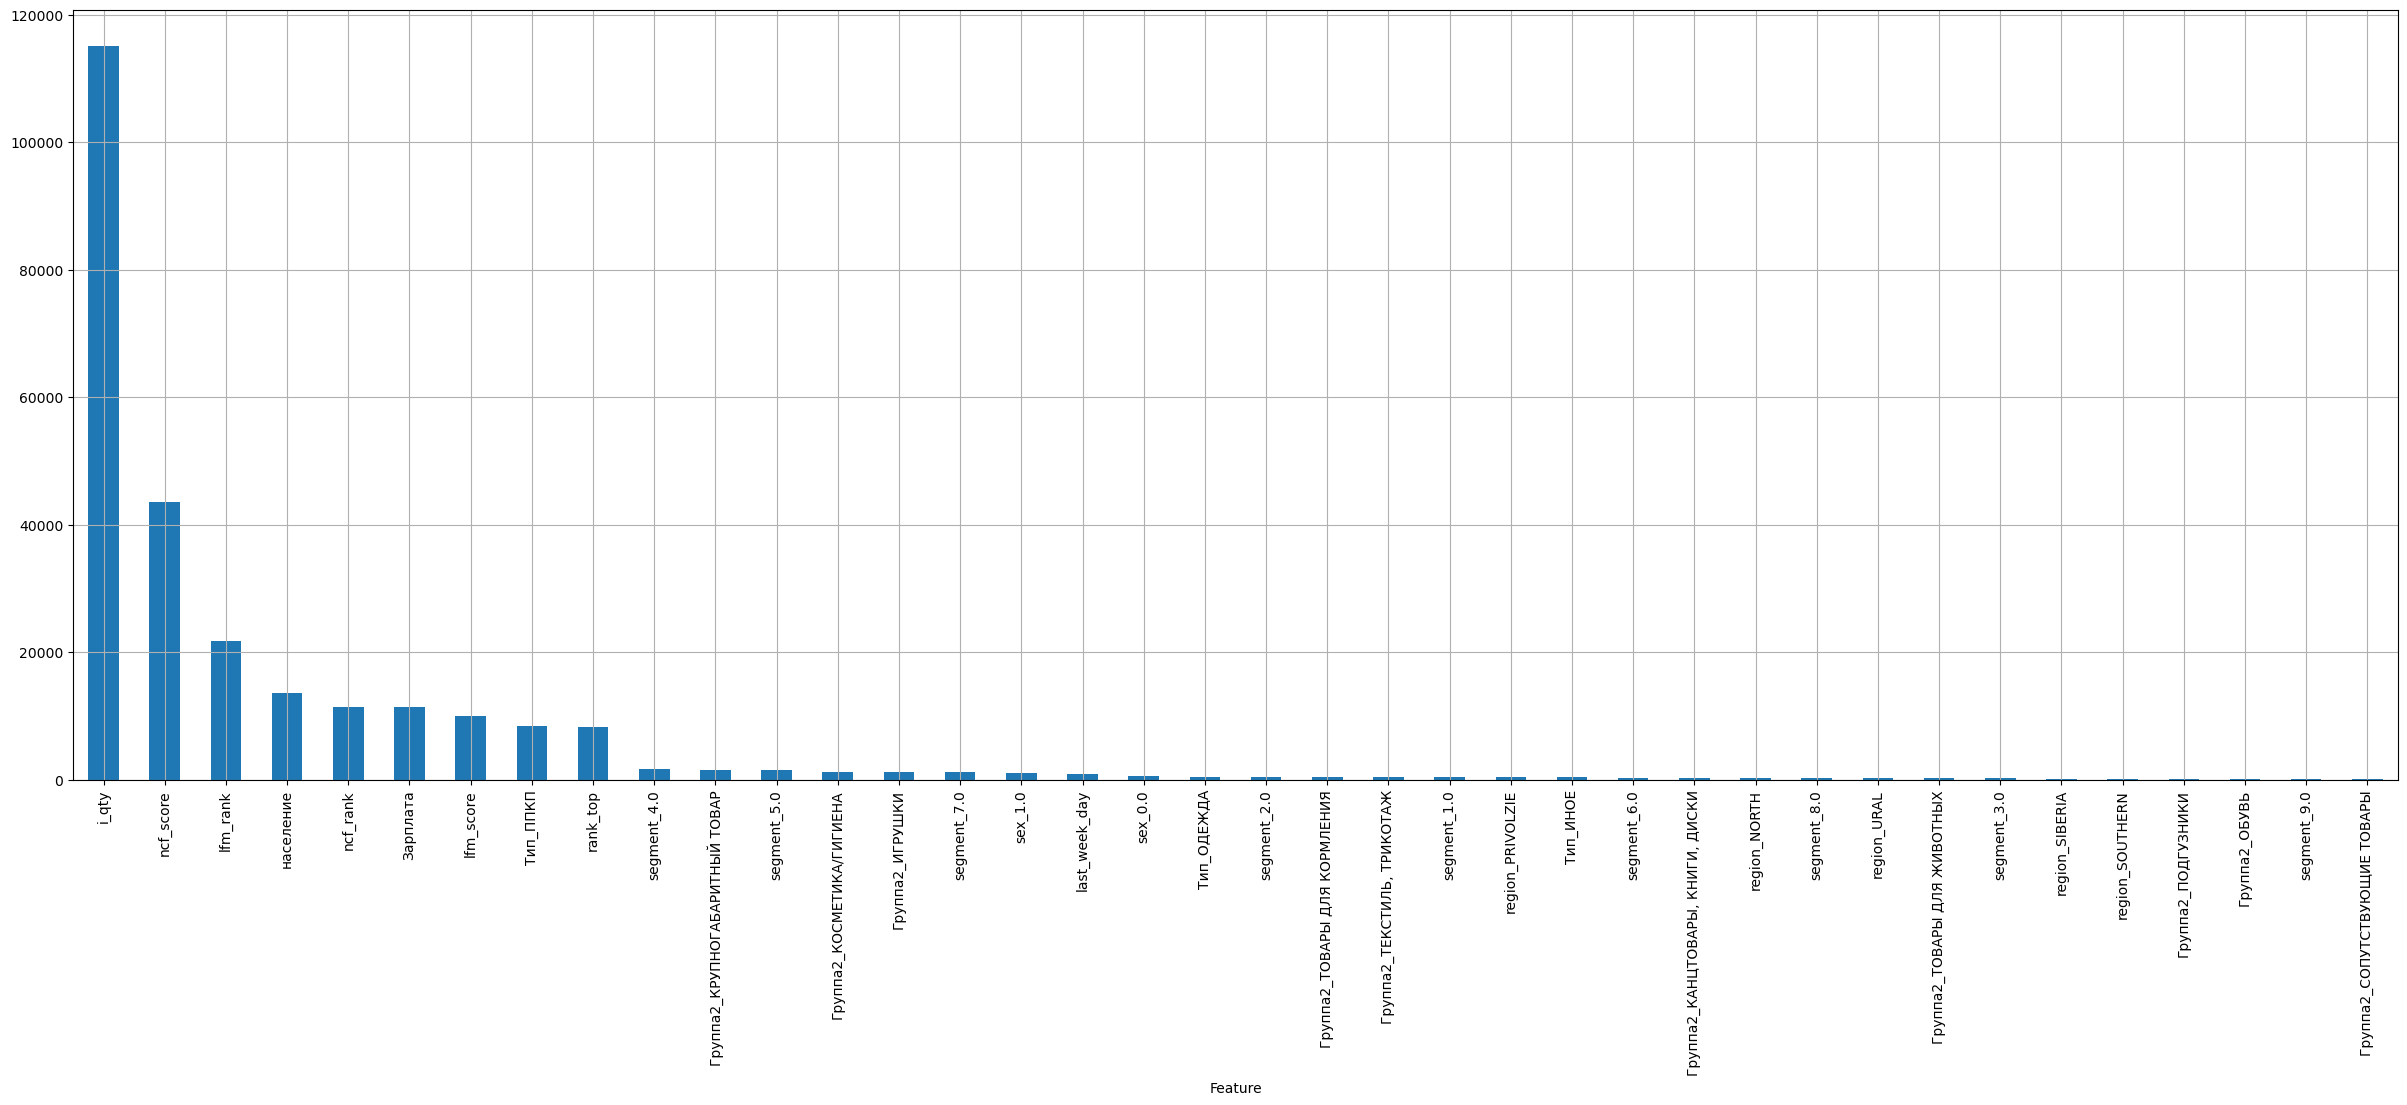

In [130]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

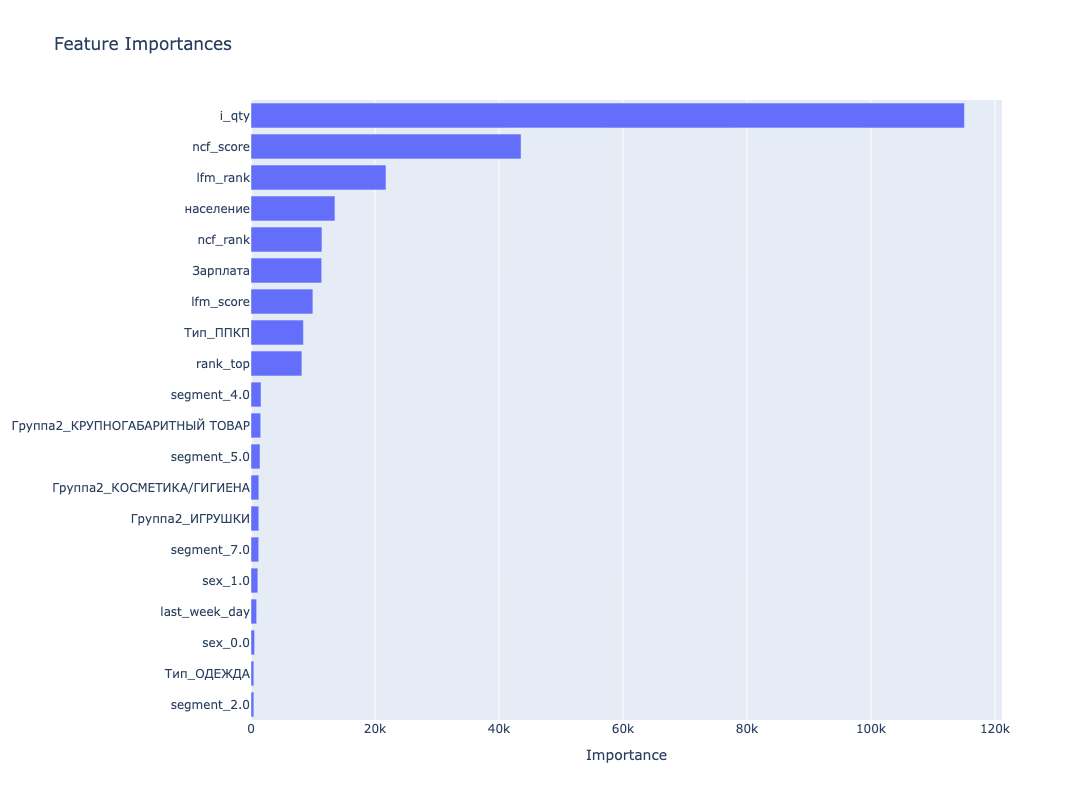

In [193]:
import plotly.graph_objects as go
import plotly
import plotly.graph_objs as go
import plotly.express as px

top10 = fast_fi.head(20)

fig = go.Figure(go.Bar(
            y=top10.Feature.values[::-1],
            x=top10.Importance.values[::-1],
            orientation='h',

            ))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title='Feature Importances',
    xaxis_title='Importance'
    )

fig.show()

In [257]:
def objective(trial,data=X_train_sc, target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 10, 10000),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [123]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param, eval_metric='logloss')  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    # roc_auc = roc_auc_score(test_y, preds[:, 1])
    # recall = recall_score(test_y, preds)
    fbeta = fbeta_score(test_y, preds, beta=1.5)
    return fbeta

In [258]:
%%time
study = optuna.create_study(direction='maximize', study_name="xgb_tuning")
study.optimize(objective, n_trials=100)

[I 2023-04-28 20:18:24,722] A new study created in memory with name: xgb_tuning
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Use

CPU times: user 10h 27min 58s, sys: 34min 39s, total: 11h 2min 38s
Wall time: 2h 18min 10s


In [260]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'lambda': 0.11942334620907365, 'alpha': 1.0363650907766482, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 493, 'max_depth': 11, 'random_state': 123, 'min_child_weight': 32}


roc auc:  {'lambda': 1.7421477167896806, 'alpha': 0.00489780565711341, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 4873, 'max_depth': 5, 'random_state': 123, 'min_child_weight': 1}

In [83]:
# import plotly.graph_objects as go

# features = X_train.columns
# importances = ctb_model.feature_importances_
# indices = np.argsort(importances)


# fig = go.Figure(go.Bar(
#             x=importances[indices],
#             y=[features[i] for i in indices],
#             orientation='h',

#             ))

# fig.update_layout(
#     autosize=False,
#     width=900,
#     height=900,
#     title='Feature Importances',
#     xaxis_title='Relative Importance'
#     )

# fig.show()

## Оценим метрики модели 

In [131]:
y_pred = automl_rd.predict(test_feat.drop(['target'], axis=1))

In [132]:
y_test = test_feat['target']

In [133]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred.data[:, 0]):.2f}"

'ROC AUC score = 0.83'

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost 
- Сравниваем


In [44]:
# # for test 
# pred_feats = lfm\
#                 .merge(
#                         ncf,
#                         on=['user_id', 'item_id'],
#                         how='outer')

In [134]:
pred_feats = lfm\
                .merge(
                        popular,
                        on=['user_id', 'item_id'],
                        how='outer')\
                .merge(
                        ncf,
                        on=['user_id', 'item_id'],
                        how='outer')

In [135]:
# фичи для теста
score_feat = pred_feats.merge(
                            stat_user_features,
                            on=['user_id'],
                            how='left')\
                        .merge(
                            stat_item_features,
                            on=['item_id'],
                            how='left')\
                        .merge(
                            train[['user_id', 'item_id', 'i_qty', 'last_month', 'last_week_day']],
                            on=['user_id', 'item_id'],
                            how='left')

In [136]:
score_feat = score_feat.drop(['user_id', 'item_id'], axis=1)

In [137]:
# catboost predict_proba
ctb_prediction = automl_rd.predict(score_feat)

In [138]:
pred_feats['ctb_pred'] = ctb_prediction.data[:, 0]

In [139]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
pred_feats = pred_feats.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
pred_feats['rank_ctb'] = pred_feats.groupby('user_id').cumcount() + 1

In [140]:
model_2step_metrics_ctb = compute_metrics(test[['user_id', 'item_id']],
                                       pred_feats, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics_ctb

Precision@1     0.411178
Recall@1        0.195518
Precision@2     0.319940
Recall@2        0.265428
Precision@3     0.268278
Recall@3        0.306668
Precision@4     0.230363
Recall@4        0.333391
Precision@5     0.206828
Recall@5        0.358252
Precision@6     0.187210
Recall@6        0.377827
Precision@7     0.170868
Recall@7        0.394308
Precision@8     0.157931
Recall@8        0.408009
Precision@9     0.146861
Recall@9        0.421121
Precision@10    0.137160
Recall@10       0.431827
MAP@10          0.343491
MRR             0.512371
dtype: float64

In [177]:
python_project/recsys_project/rec_models_valid/final_res_com_metrics/metrics_final.csv

'/Users/mariafar/python_project/recsys_project/rec_models_valid'

In [182]:
pd.read_csv('final_res_com_metrics/metrics_final.csv', index_col=0)

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
model_2step_popular,0.044424,0.008448,0.036114,0.014010,0.033444,0.018620,0.028785,0.020489,0.024539,0.021279,...,0.018780,0.022010,0.016735,0.022233,0.015110,0.022400,0.013750,0.022520,0.016432,0.059832
ncf,0.102146,0.032773,0.087186,0.054152,0.077365,0.068703,0.071396,0.083197,0.066908,0.096435,...,0.058498,0.116078,0.054813,0.123273,0.052685,0.131665,0.050771,0.140563,0.086287,0.186026
lightfm,0.227259,0.095387,0.214869,0.174228,0.193210,0.238418,0.169387,0.268047,0.149471,0.286878,...,0.119717,0.309900,0.108870,0.318054,0.099527,0.324715,0.092747,0.334127,0.214799,0.366571


In [185]:
df_metrics = pd.concat([
    pd.DataFrame(model_2step_metrics_ctb).transpose(),
    pd.read_csv('final_res_com_metrics/metrics_final.csv', index_col=0)
])

df_metrics.index = ['model_2step_lama', 'model_2step_popular', 'model_2step_ncf', 'model_2step_lightfm']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
model_2step_lama,0.411178,0.195518,0.319940,0.265428,0.268278,0.306668,0.230363,0.333391,0.206828,0.358252,...,0.170868,0.394308,0.157931,0.408009,0.146861,0.421121,0.137160,0.431827,0.343491,0.512371
model_2step_popular,0.044424,0.008448,0.036114,0.014010,0.033444,0.018620,0.028785,0.020489,0.024539,0.021279,...,0.018780,0.022010,0.016735,0.022233,0.015110,0.022400,0.013750,0.022520,0.016432,0.059832
model_2step_ncf,0.102146,0.032773,0.087186,0.054152,0.077365,0.068703,0.071396,0.083197,0.066908,0.096435,...,0.058498,0.116078,0.054813,0.123273,0.052685,0.131665,0.050771,0.140563,0.086287,0.186026
model_2step_lightfm,0.227259,0.095387,0.214869,0.174228,0.193210,0.238418,0.169387,0.268047,0.149471,0.286878,...,0.119717,0.309900,0.108870,0.318054,0.099527,0.324715,0.092747,0.334127,0.214799,0.366571


In [167]:
import matplotlib.pyplot as plt

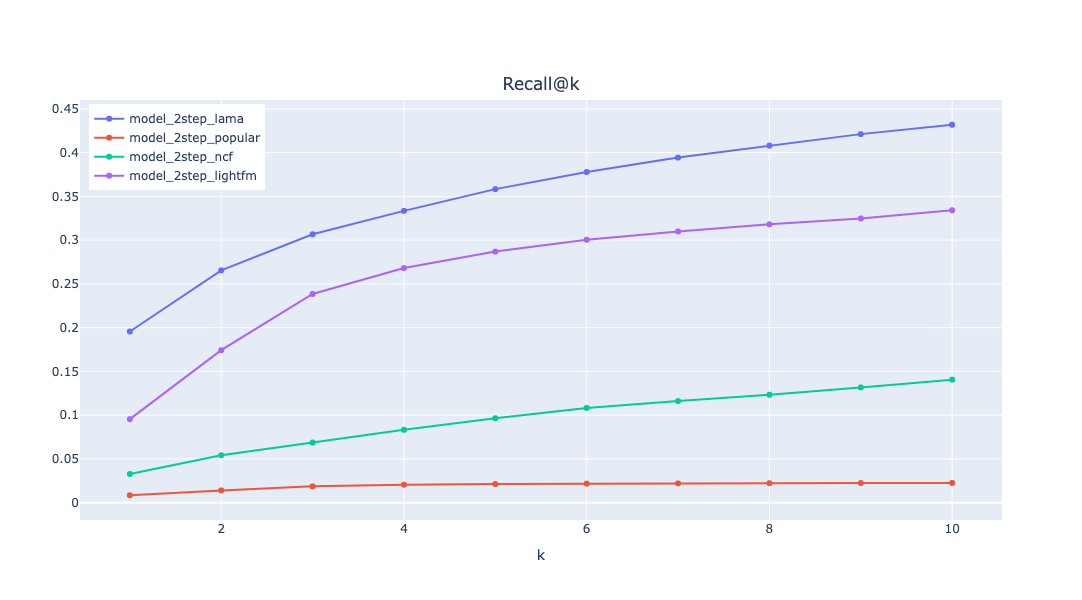

In [188]:
for indx, metric in enumerate([f'Recall@']):
    fig = go.Figure()
    for model in df_metrics.index:
        #print(model)
        fig.add_trace(go.Scatter(
                                x=list(range(1, 11)), 
                                y=df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                                name=model, ))
    fig.update_layout(
                      title=dict(text=f'{metric}k', font=dict(size=17)),
                      xaxis_title="k",
                      width=700,
                      height=600,
                      title_x=0.5,
                      title_y=0.87,
                    legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.01))

    fig.show()

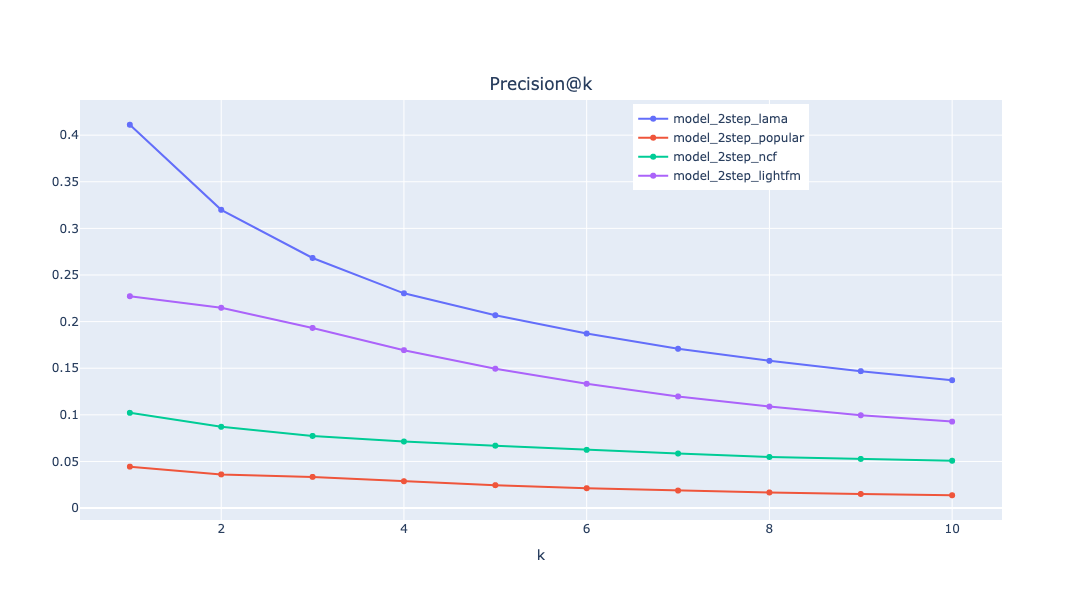

In [192]:
for indx, metric in enumerate([f'Precision@']):
    fig = go.Figure()
    for model in df_metrics.index:
        #print(model)
        fig.add_trace(go.Scatter(
                                x=list(range(1, 11)), 
                                y=df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                                name=model, ))
    fig.update_layout(
                      title=dict(text=f'{metric}k', font=dict(size=17)),
                      xaxis_title="k",
                      width=700,
                      height=600,
                      title_x=0.5,
                      title_y=0.87,
                    legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.60))

    fig.show()